# Restricted Boltzmann Machine features for digit classification

Adapted from http://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html

For greyscale image data where pixel values can be interpreted as degrees of blackness on a white background, like handwritten digit recognition, the Bernoulli Restricted Boltzmann machine model (BernoulliRBM) can perform effective non-linear feature extraction.

In order to learn good latent representations from a small dataset, we artificially generate more labeled data by perturbing the training data with linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a BernoulliRBM feature extractor and a LogisticRegression classifier. The hyperparameters of the entire model (learning rate, hidden layer size, regularization) were optimized by grid search, but the search is not reproduced here because of runtime constraints.

Logistic regression on raw pixel values is presented for comparison. The example shows that the features extracted by the BernoulliRBM help improve the classification accuracy.

In [1]:
# Original Python Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

using ScikitLearn
using PyCall: @pyimport
using PyPlot

using ScikitLearn.Pipelines: Pipeline
using ScikitLearn.CrossValidation: train_test_split
@pyimport scipy.ndimage as ndimage
@sk_import neural_network: BernoulliRBM
@sk_import datasets: load_digits
@sk_import linear_model: LogisticRegression
@sk_import metrics: classification_report

In [2]:
###############################################################################
# Setting up

    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
function nudge_dataset(X, Y)
    direction_vectors = Any[
        [0 1 0
         0 0 0
         0 0 0],
        [0 0 0
         1 0 0
         0 0 0],

        [0 0 0
         0 0 1
         0 0 0],

        [0 0 0
         0 0 0
         0 1 0]]

    shift(x, w) = ndimage.convolve(reshape(x, 8, 8); mode="constant", weights=w)[:]
    X = vcat(X, Any[vcat([shift(X[i, :], vector)' for i in 1:size(X, 1)]...)
                 for vector in direction_vectors]...)
    Y = vcat(fill(Y, 5)...)
    return X, Y
end

# Load Data
digits = load_digits()
X = digits["data"]
X, Y = nudge_dataset(X, digits["target"]);

X = (X .- minimum(X, dims=1)) ./ (maximum(X, dims=1) .+ 0.0001);

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0);

# Models we will use
logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=true)

PyObject BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=256, n_iter=10,
       random_state=0, verbose=True)

In [3]:
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])

###############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm[:learning_rate] = 0.06
rbm[:n_iter] = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm[:n_components] = 100
logistic[:C] = 6000.0

# Training RBM-Logistic Pipeline
fit!(classifier, X_train, Y_train)

# Training Logistic regression
logistic_classifier = LogisticRegression(C=100.0)
fit!(logistic_classifier, X_train, Y_train);

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.54, time = 0.21s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.94, time = 0.28s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.98, time = 0.28s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.98, time = 0.26s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.48, time = 0.24s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.25s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.93, time = 0.28s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.49, time = 0.30s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.27, time = 0.28s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.18, time = 0.29s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.02, time = 0.31s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.73, time = 0.25s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.86, time = 0.25s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.64, time = 0.27s
[BernoulliRBM] Iteration 15, 

Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.99      0.98      0.99       174
          1       0.94      0.95      0.94       184
          2       0.95      0.98      0.96       166
          3       0.96      0.87      0.91       194
          4       0.96      0.95      0.96       186
          5       0.90      0.92      0.91       181
          6       0.99      0.98      0.98       207
          7       0.94      0.98      0.96       154
          8       0.89      0.90      0.89       182
          9       0.90      0.92      0.91       169

avg / total       0.94      0.94      0.94      1797

Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.86      0.94      0.90       174
          1       0.55      0.53      0.54       184
          2       0.79      0.86      0.82       166
          3       0.78      0.73      0.75       194
         

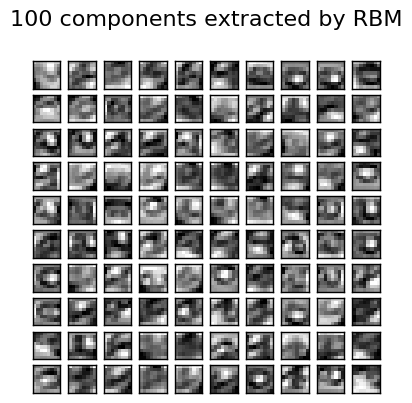

In [4]:
###############################################################################
# Evaluation

report = classification_report(Y_test, predict(classifier, X_test))
println("Logistic regression using RBM features:\n$(report)")
report2 = classification_report(Y_test, predict(logistic_classifier, X_test))
print("Logistic regression using raw pixel features:\n$(report2)\n")

###############################################################################
# Plotting

figure(figsize=(4.2, 4))
for i in 1:size(rbm[:components_], 1)
    comp = rbm[:components_][i, :]
    subplot(10, 10, i)
    imshow(reshape(comp, 8, 8), cmap=get_cmap("gray_r"),
           interpolation="nearest")
    xticks(())
    yticks(())
end

suptitle("100 components extracted by RBM", fontsize=16)
subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)